<h1><center> Arrival Time Visualization <br><br> 
<center> Differential Privacy Application<br><br> 
Wendy Shi</center></center>

# Table of Content

1. [Load Data](#Load-Data)
2. [Functions](#Functions)
3. [Box plot for arrival time](#Box-plot-for-arrival-time)
4. [Box Plot for Peak Times](#Box-Plot-for-Peak-Times)

# Preparation

In [2]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats
import statistics

## Population data for each county

In [3]:
ori_mt = pd.read_csv("WA_Data/Aggregate/WA_ori_agg.csv")
ori_mt = ori_mt.drop(columns = 'Unnamed: 0')
ori_mt.head(3)

,53001,53003,53005,53007,53009,53011,53015,53017,53021,53025,...,53057,53059,53061,53063,53065,53067,53071,53073,53075,53077
0,0.394639,0.000000,0.055023,0.030399,0.000545,0.024406,0.007736,0.015036,0.042820,0.023317,...,0.000000,0.000000,0.029200,0.085422,0.003922,0.004249,0.008499,0.046306,0.004140,0.026694
1,0.000000,0.917968,0.003904,0.000220,0.000000,0.001100,0.000275,0.000110,0.003299,0.000385,...,0.002694,0.000000,0.003739,0.013800,0.002804,0.001869,0.001649,0.000110,0.016439,0.000330
2,0.001535,0.000008,0.738961,0.000639,0.000240,0.005779,0.000496,0.000184,0.161487,0.004964,...,0.000192,0.000016,0.005532,0.010416,0.000919,0.002710,0.006739,0.002382,0.000576,0.023861


In [4]:
column_names = ['S', 'E', 'I', 'R']
pop_2020 = pd.read_csv("../../Data/us_shapefile_county.csv")
pop_2020 = pop_2020[['GEO_ID','pop2020']]
pop_2020["GEO_ID"] = pop_2020["GEO_ID"].apply(lambda x: f"{int(x):05d}")

rename = {'GEO_ID':'GEOID'}
pop_2020 = pop_2020.rename(columns = rename)

print(pop_2020.shape)
pop_2020.tail(3)

(3109, 2)


,GEOID,pop2020
3106,06037,9989165.0
3107,46113,14309.0
3108,51515,6599.0


In [5]:
county_list = ori_mt.columns.tolist()
county_pop = pd.DataFrame()
county_pop['GEOID'] = county_list
county_pop.head(3)

,GEOID
0,53001
1,53003
2,53005


In [6]:
# Get list for the population
joined = pd.merge(county_pop, pop_2020, on = 'GEOID', how = 'left')
pop_list = joined['pop2020'].tolist()
print(f'Length of the population list: {len(pop_list)}')
joined.head()

Length of the population list: 34


,GEOID,pop2020
0,53001,20605.0
1,53003,22290.0
2,53005,207230.0
3,53007,79185.0
4,53009,77280.0


# Load Data

## Individual Data

In [44]:
import pickle
with open('WA_Data/Individual/20_simulations_ori_WA_indi.pkl', 'rb') as f:
    ori_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P8_WA_indi.pkl', 'rb') as f:
    P8_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P5_WA_indi.pkl', 'rb') as f:
    P5_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P3_WA_indi.pkl', 'rb') as f:
    P3_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P1_WA_indi.pkl', 'rb') as f:
    P1_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P05_WA_indi.pkl', 'rb') as f:
    P05_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P01_WA_indi.pkl', 'rb') as f:
    P01_data_indi= pickle.load(f)
    
with open('WA_Data/Individual/20_simulations_P005_WA_indi.pkl', 'rb') as f:
    P005_data_indi= pickle.load(f)

## Aggregate Data

In [45]:
import pickle
with open('WA_Data/Aggregate/20_simulations_ori_WA_agg.pkl', 'rb') as f:
    ori_data_agg= pickle.load(f)
    
with open('WA_Data/Aggregate/20_simulations_P5_WA_agg.pkl', 'rb') as f:
    P5_data_agg= pickle.load(f)
    
with open('WA_Data/Aggregate/20_simulations_P1_WA_agg.pkl', 'rb') as f:
    P1_data_agg= pickle.load(f)
    
with open('WA_Data/Aggregate/20_simulations_P05_WA_agg.pkl', 'rb') as f:
    P05_data_agg= pickle.load(f)

with open('WA_Data/Aggregate/20_simulations_P01_WA_agg.pkl', 'rb') as f:
    P01_data_agg= pickle.load(f)

with open('WA_Data/Aggregate/20_simulations_P005_WA_agg.pkl', 'rb') as f:
    P005_data_agg= pickle.load(f)

with open('WA_Data/Aggregate/20_simulations_P001_WA_agg.pkl', 'rb') as f:
    P001_data_agg= pickle.load(f)

# Functions

## Arrival_function

In [129]:
#Loop
def arrival_date_list(Df):
    
    #Mean arrival time
    the_34_mean_arrival_ori = []
    Ii_data = pd.DataFrame()
    
    #for each node
    for i in range(34):
        
        #if i % 500 == 0: 
        #print(i)
        
        #For each simulation
        for j in range(20):
            
            #This extract data for the i_th similation
            data = Df[j]
            times, S_values, E_values, I_values, R_values = zip(*data)
            
            #I data for each similation for all node 
            I_list = list(zip(*I_values))
            
            Ii_simu_j = I_list[i] #This specifies we want the i county
            Ii_data[f'simu{j+1}'] = Ii_simu_j
        
        arrival_dates = []
        
        arrival_number = pop_list[i] * 0.0009
        
        for n in range(20):
            row_index = Ii_data[Ii_data[f"simu{n+1}"] > arrival_number].index[0]
            arrival_day = row_index + 1
            arrival_dates.append(arrival_day)
            
        mean_arrival = statistics.mean(arrival_dates)
        the_34_mean_arrival_ori.append(mean_arrival)
        
    return(the_34_mean_arrival_ori)

## Peak Dats Function

In [130]:
#Loop
def peak_date_list(Df):
    
    #Mean arrival time
    the_34_mean_peak_ori = []
    Ii_data = pd.DataFrame()
    
    for i in range(34):
        
        #if i % 500 == 0: 
        #    print(i)
        
        #For each simulation
        for j in range(20):
            
            #This extract data for the i_th similation
            data = Df[j]
            times, S_values, E_values, I_values, R_values = zip(*data)
            
            #I data for each similation for all node 
            I_list = list(zip(*I_values))
            
            Ii_simu_j = I_list[i] #This specifies we want the i county
            Ii_data[f'simu{j+1}'] = Ii_simu_j
        
        peak_dates = []
        
        for n in range(20):
            row_index = Ii_data[f"simu{n+1}"].idxmax()
            peak_day = row_index + 1
            peak_dates.append(peak_day)
            
        mean_peak = statistics.mean(peak_dates)
        the_34_mean_peak_ori.append(mean_peak)
        
    return(the_34_mean_peak_ori)

# Apply Function

In [131]:
#Individual Data
mean_arrival_ori_indi = arrival_date_list(ori_data_indi)
mean_arrival_P8_indi = arrival_date_list(P8_data_indi)
mean_arrival_P5_indi = arrival_date_list(P5_data_indi)
mean_arrival_P3_indi = arrival_date_list(P3_data_indi)
mean_arrival_P1_indi = arrival_date_list(P1_data_indi)
mean_arrival_P05_indi = arrival_date_list(P05_data_indi)
mean_arrival_P01_indi = arrival_date_list(P01_data_indi)
mean_arrival_P005_indi = arrival_date_list(P005_data_indi)

In [132]:
#Aggregate
mean_arrival_ori_agg = arrival_date_list(ori_data_agg)
mean_arrival_P5_agg = arrival_date_list(P5_data_agg)
mean_arrival_P1_agg = arrival_date_list(P1_data_agg)
mean_arrival_P05_agg = arrival_date_list(P05_data_agg)
mean_arrival_P01_agg = arrival_date_list(P01_data_agg)
mean_arrival_P005_agg = arrival_date_list(P005_data_agg)
mean_arrival_P001_agg = arrival_date_list(P001_data_agg)

# Box plot for arrival time

In [22]:
#mean_arrival_P8_indi

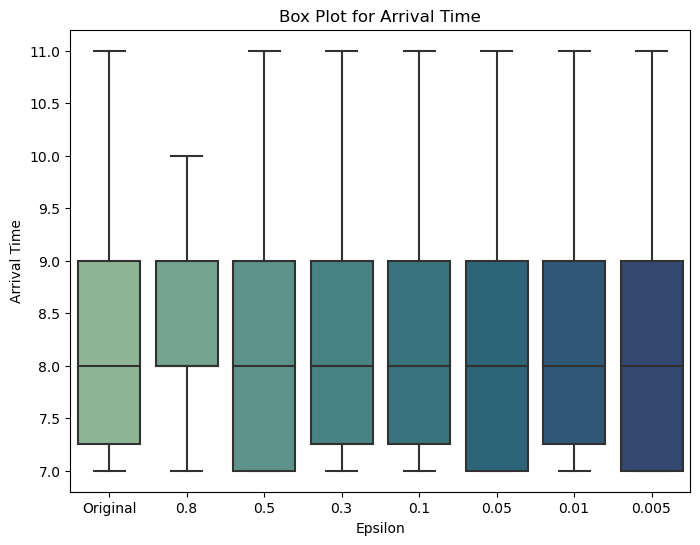

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_arrival_ori_indi, mean_arrival_P8_indi, mean_arrival_P5_indi, mean_arrival_P3_indi, 
        mean_arrival_P1_indi, mean_arrival_P05_indi, mean_arrival_P01_indi, mean_arrival_P005_indi]

color = sns.color_palette("crest", n_colors =8)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data = data, palette=color, saturation= 0.7,showfliers=False)

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Original', '0.8', '0.5', '0.3', '0.1', 
                                      '0.05', '0.01', '0.005'])
plt.title("Box Plot for Arrival Time")
plt.ylabel("Arrival Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("arrival_time_box_indi_WA.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## Aggregate Data

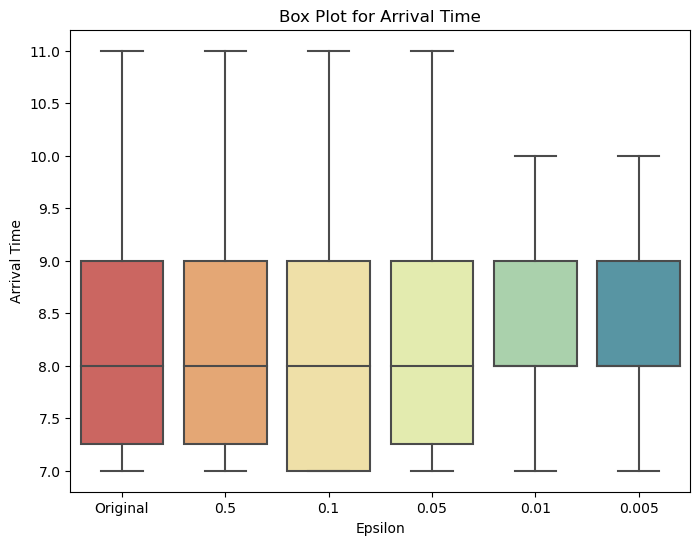

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_arrival_ori_agg, mean_arrival_P5_agg, mean_arrival_P1_agg, mean_arrival_P05_agg,
        mean_arrival_P01_agg, mean_arrival_P005_agg]

#color = sns.color_palette("crest", n_colors =8)
color = sns.color_palette("Spectral", n_colors =6)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data = data, palette=color, saturation= 0.7,showfliers=False)

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5], ['Original', '0.5', '0.1', '0.05', 
                                   '0.01', '0.005'])
plt.title("Box Plot for Arrival Time")
plt.ylabel("Arrival Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("arrival_time_box_agg_WA.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


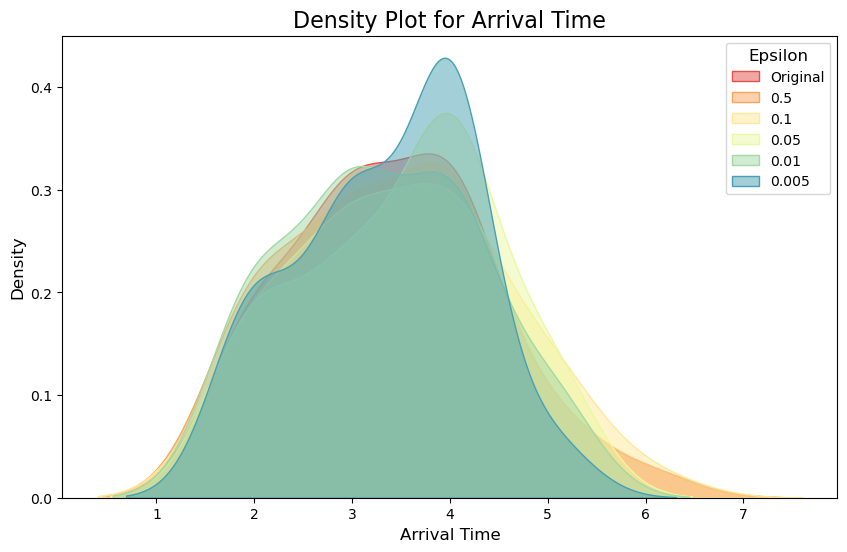

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
#data = [mean_arrival_ori_indi, mean_arrival_P8_indi, mean_arrival_P5_indi, mean_arrival_P3_indi, 
#        mean_arrival_P1_indi, mean_arrival_P05_indi, mean_arrival_P01_indi, mean_arrival_P005_indi]
data = [mean_arrival_ori_agg, mean_arrival_P5_agg, mean_arrival_P1_agg, mean_arrival_P05_agg,
        mean_arrival_P01_agg, mean_arrival_P005_agg]

#labels = ['Original', '0.8', '0.5', '0.3', '0.1', '0.05', '0.01', '0.005']
labels = ['Original', '0.5', '0.1', '0.05', '0.01', '0.005']

# Generate a color palette
#color = sns.color_palette("crest", n_colors=8)
color = sns.color_palette("Spectral", n_colors =6)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Loop through datasets to plot their density
for i, dataset in enumerate(data):
    sns.kdeplot(dataset, label=labels[i], color=color[i], fill=True, alpha=0.5)

# Adding labels and title
plt.title("Density Plot for Arrival Time", fontsize=16)
plt.xlabel("Arrival Time", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Adding a legend
plt.legend(title="Epsilon", fontsize=10, title_fontsize=12)

# Save plot (optional)
#plt.savefig("arrival_time_density.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# Box Plot for Peak Times

In [136]:
#Individual Data
mean_peak_ori_indi = peak_date_list(ori_data_indi)
mean_peak_P8_indi = peak_date_list(P8_data_indi)
mean_peak_P5_indi = peak_date_list(P5_data_indi)
mean_peak_P3_indi = peak_date_list(P3_data_indi)
mean_peak_P1_indi = peak_date_list(P1_data_indi)
mean_peak_P05_indi = peak_date_list(P05_data_indi)
mean_peak_P01_indi = peak_date_list(P01_data_indi)
mean_peak_P005_indi = peak_date_list(P005_data_indi)

In [137]:
#Aggregate Data
mean_peak_ori_agg = peak_date_list(ori_data_agg)
mean_peak_P5_agg = peak_date_list(P5_data_agg)
mean_peak_P1_agg = peak_date_list(P1_data_agg)
mean_peak_P05_agg = peak_date_list(P05_data_agg)
mean_peak_P01_agg = peak_date_list(P01_data_agg)
mean_peak_P005_agg = peak_date_list(P005_data_agg)
mean_peak_P001_agg = peak_date_list(P001_data_agg)

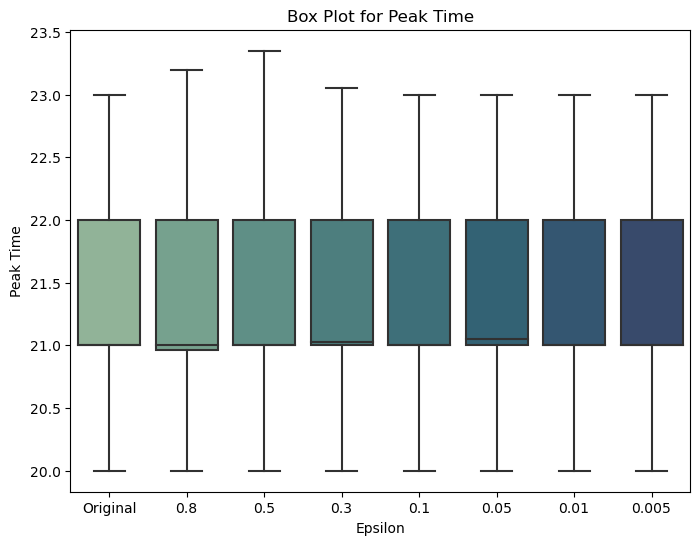

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_peak_ori_indi, mean_peak_P8_indi, mean_peak_P5_indi, mean_peak_P3_indi,
        mean_peak_P1_indi, mean_peak_P05_indi, mean_peak_P01_indi, mean_peak_P005_indi]

color = sns.color_palette("crest", n_colors =8)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, palette=color, saturation=0.6, showfliers=False)

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Original', '0.8', '0.5', '0.3', '0.1', '0.05', '0.01', '0.005'])
#plt.xticks([0, 1, 2, 3, 4, 5], ['Original', '0.5', '0.1', '0.05', '0.01', '0.005'])
plt.title("Box Plot for Peak Time")
plt.ylabel("Peak Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("peak_time_box_indi_WA.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


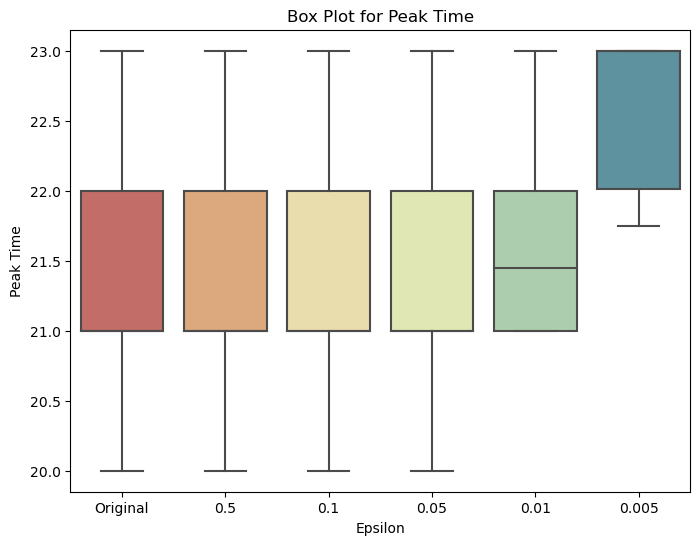

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_peak_ori_agg, mean_peak_P5_agg, mean_peak_P1_agg, mean_peak_P05_agg,
        mean_peak_P01_agg, mean_peak_P005_agg]

color = sns.color_palette("Spectral", n_colors =6)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, palette=color, saturation=0.6, showfliers=False)

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5], ['Original', '0.5', '0.1', '0.05', '0.01', '0.005'])
plt.title("Box Plot for Peak Time")
plt.ylabel("Peak Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("peak_time_box_agg_WA.png", dpi=300, bbox_inches='tight')

# Display the plot

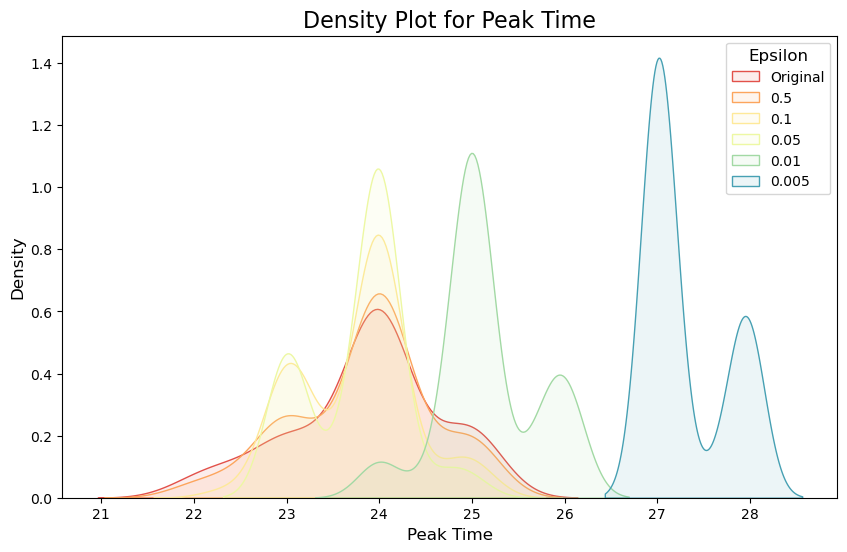

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
#data = [mean_peak_ori_indi, mean_peak_P8_indi, mean_peak_P5_indi, mean_peak_P3_indi,
#        mean_peak_P1_indi, mean_peak_P05_indi, mean_peak_P01_indi, mean_peak_P005_indi]
data = [mean_peak_ori_agg, mean_peak_P5_agg, mean_peak_P1_agg, mean_peak_P05_agg,
        mean_peak_P01_agg, mean_peak_P005_agg]

#Labels
#labels = ['Original', '0.8', '0.5', '0.3', '0.1', '0.05', '0.01', '0.005']
labels = ['Original', '0.5', '0.1', '0.05', '0.01', '0.005']

# Generate a color palette
#color = sns.color_palette("Spectral", n_colors= 8)
color = sns.color_palette("Spectral", n_colors= 6)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Loop through datasets to plot their density
for i, dataset in enumerate(data):
    sns.kdeplot(dataset, label=labels[i], color=color[i], fill=True, alpha=0.1)

# Adding labels and title
plt.title("Density Plot for Peak Time", fontsize=16)
plt.xlabel("Peak Time", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Adding a legend
plt.legend(title="Epsilon", fontsize=10, title_fontsize=12)

# Save plot (optional)
#plt.savefig("peak_time_density_agg.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
